In [1]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp

from datasets import load_dataset

2023-11-20 16:23:02.745833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
NUM_STEPS = 3

In [2]:
ds = load_dataset("mozilla-foundation/common_voice_11_0", "en", split='train[:100]')

Found cached dataset common_voice_11_0 (/home/hetricke/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/en/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631)


In [3]:
def transcript_prep(transcription, audio_len):
    if transcription.startswith('"') and transcription.endswith('"'):
        # we can remove trailing quotation marks as they do not affect the transcription
        transcription = transcription[1:-1]

    if len(transcription) > 0:
        if transcription[-1] not in [".", "?", "!"]:
            # append a full-stop to sentences that do not end in punctuation
            transcription = transcription + "."

        t_len = len(transcription)
        t_len_mod = transcription%audio_len
        t_step = int(t_len/audio_len)

        transcript_pieces = []
        index=0;

        while (index < t_len-t_len_mod-1):
            transcript_pieces.append(transcription[index:index+t_step])
            index += t_step

        transcript_pieces.append(transcript_pieces[index:t_len])

    return transcript_pieces


In [8]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [13]:
def audio_to_spectrogram(batch):
    mp3_audio = AudioSegment.from_file(batch['path'], format="mp3")  # read mp3

    start_trim = detect_leading_silence(mp3_audio)
    end_trim = detect_leading_silence(mp3_audio.reverse())

    duration = len(mp3_audio)    
    trimmed_sound = mp3_audio[start_trim:duration-end_trim]

    wname = mktemp('.wav')  # use temporary file
    trimmed_sound.export(wname, format="wav")  # convert to wav
    FS, data = wavfile.read(wname)  # read wav file

    file_name = audio_file[:-4] + ".png"

    plt.specgram(data, Fs=FS, NFFT=128, noverlap=0)  # plot
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight')

    
    img = keras.preprocessing.image.load_img(file_name)
    img_array = keras.preprocessing.image.img_to_array(img)

    samples = len(trimmed_sound)-1
    features = (img_array.shape[0]/samples)*img_array.shape[0]
    time_steps = 1
    output = np.reshape(img_array, (samples, time_steps, features ))


    transcript_prep(batch["sentence"], samples)
    


    #convert image into 


    #reshape the spectogram into a 3d array that goes (num samples x timesteps x features)
    #1 sample is how many times this gets run through
    #timesteps is how far backward to grab (so that's a value that can be played with!)
    #num samples is I think how long it is (so grab the mp3 length)
    #slice the image accordingly
    #convert the image into an array (reference the obj detection) to use for the features
    #profit

    return output

In [10]:

def prepare_dataset(batch):
  """Function to preprocess the dataset with the .map method"""
  batch["sentence"] = transcript_prep(batch["sentence"])
  batch["path"] = audio_to_spectrogram(batch["path"])

  return batch



preprocess dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

preprocess dataset:  29%|██▉       | 29/100 [00:31<02:04,  1.75s/ examples]/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
preprocess dataset:  64%|██████▍   | 64/100 [02:02<01:56,  3.25s/ examples]/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
preprocess dataset:  83%|████████▎ | 83/100 [03:11<01:08,  4.02s/ examples]/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
preprocess dataset:  85%|████████▌ | 85/100 [03:20<01:02,  4.14s/ examples]/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero enco

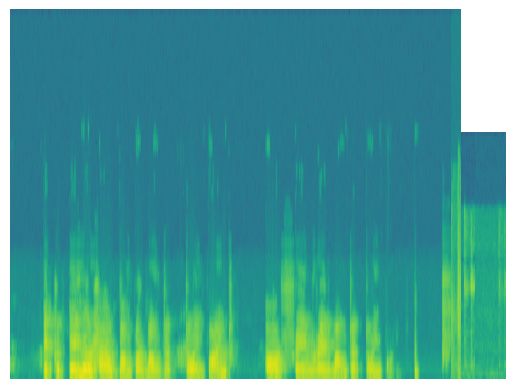

In [14]:
ds = ds.map(prepare_dataset, desc="preprocess dataset")

In [15]:
# split = ds.train_test_split(test_size = 0.2,train_size = 0.8)
# train = split['train']
# test = split['test']

x_train = ds["path"][:80]
y_train = ds["sentence"][:80]

x_test = ds["path"][:-20]
y_test = ds["sentence"][:-20]


In [9]:
#build model
model = keras.Sequential()
model.add(keras.layers.Dense(units = 128, activation = 'relu', input_shape = None))
model.add(keras.layers.Dense(units = 128, activation='relu'))
model.add(keras.layers.Dense(units = 128, activation ='relu'))
model.add(keras.layers.SimpleRNN(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(29, activation = 'softmax'))
model.compile(optimizer='adam', metrics=['accuracy'])

2023-11-18 15:37:58.542654: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
#train model
#what you might have to do is iteratively run fit on all the audio samples
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size= 10)


Epoch 1/100


ValueError: in user code:

    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (10,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(10,), dtype=string)
      • training=True
      • mask=None


In [ ]:
#add computer i/o for speech recognition